In [304]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)
import spacy

import torch.utils.data as tud
from collections import Counter, defaultdict
import operator
import os, math
import numpy as np
import random
import copy
import pandas as pd

import datetime

import statsmodels.formula.api as smf

import matplotlib.pyplot as plt


In [2]:
# set the random seeds so the experiments can be replicated exactly
seed = 30255
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

IMPORTING DATA, PREPROCESSING AND SPLITTING INTO DATASETS 

In [3]:
conflict_df = pd.read_csv('./data/050319_acled_all.csv')

In [4]:
conflict_df.columns

Index(['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'event_date',
       'year', 'time_precision', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'region', 'country', 'admin1', 'admin2', 'admin3',
       'location', 'latitude', 'longitude', 'geo_precision', 'source',
       'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3'],
      dtype='object')

Removing short notes and three interaction codes that are not documented on codebook

In [5]:
conflict_df['notes_char'] = conflict_df.notes.str.len()
trimmed_conflict_df = conflict_df[conflict_df['notes_char']>=100] 
trimmed_conflict_df = trimmed_conflict_df[trimmed_conflict_df['interaction']!=88]
trimmed_conflict_df = trimmed_conflict_df[trimmed_conflict_df['interaction']!=70]
trimmed_conflict_df = trimmed_conflict_df[trimmed_conflict_df['interaction']!=77]


In [6]:
len(trimmed_conflict_df)

417003

Text(0,0.5,'% rows')

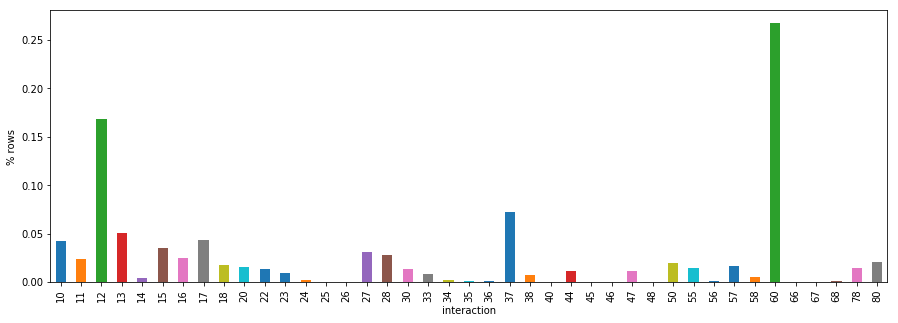

In [272]:
per_interactions = (trimmed_conflict_df.groupby('interaction').size()/len(trimmed_conflict_df)).plot.bar(figsize = (15,5))
per_interactions.set_ylabel("% rows")

Splitting data into train, dev and test. Note that training are the oldest 75% of news following a common practice of NLP projects that analyze news.

In [8]:
def split_data(data):
    # reset index
    data_idx = data.reset_index()
    
    # subsetting in .75 train and even random split the other.
    dev_test_size = round(len(data_idx)*0.25)
    tr_df = data_idx[dev_test_size:]
    dev_test_df = data_idx[:dev_test_size]
    ran_idx = np.random.choice(dev_test_size, round(dev_test_size/2), replace=False)
    dev_df = dev_test_df.iloc[ran_idx]
    test_df = dev_test_df.iloc[~ran_idx]
    
    #shuffling training so it doesn't see similar cases one after the other 
    tr_df = tr_df.sample(frac=1).reset_index(drop=True)
        
    # make them lists
    train_l = tr_df[['data_id', 'interaction', 'notes']].values.tolist()
    dev_l = dev_df[['data_id', 'interaction', 'notes']].values.tolist()
    test_l = test_df[['data_id', 'interaction', 'notes']].values.tolist()
    

    return train_l, dev_l, test_l

In [9]:
train_list, dev_list, test_list = split_data(trimmed_conflict_df)

In [10]:
print(len(train_list), len(dev_list), len(test_list))

312752 52126 52126


In [11]:
#checking = pd.read_csv('obj1/train_list.csv')
#checking.values.tolist()

In [12]:
pd.DataFrame(train_list).to_csv('obj1/train_list.csv', index = False)
pd.DataFrame(dev_list).to_csv('obj1/dev_list.csv', index = False)
pd.DataFrame(test_list).to_csv('obj1/test_list.csv', index = False)

MODEL

In [13]:
label_to_idx = {10: 0, 11: 1, 12: 2, 13: 3, 14: 4, 15: 5, 
                16: 6, 17: 7, 18: 8, 20: 9, 22: 10, 23: 11, 
                24: 12, 25: 13, 26: 14, 27: 15, 28: 16, 30: 17, 
                33: 18, 34: 19, 35: 20, 36: 21, 37: 22, 38: 23,
                40: 24, 44: 25, 45: 26, 46: 27, 47: 28, 48: 29,
                50: 30, 55: 31, 56: 32, 57: 33, 58: 34, 60: 35, 
                66: 36, 67: 37, 68: 38, 78: 39, 80: 40}
idx_to_label = [10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26,
                27, 28, 30, 33, 34, 35, 36, 37, 38, 40, 44, 45, 46, 47, 48,
                50, 55, 56, 57, 58, 60, 66, 67, 68, 78, 80]

In [14]:
# we use pre-trained word embeddings from spacy
nlp = spacy.load('en_core_web_md')

This class performs the steps of a neural network model that uses as input the 300 dimensions of spacy's word embeddings, two layers (size 128 and 100), and outputs the 41 interaction codes. 

In [15]:
class InterClassifier(nn.Module):

    def __init__(self, categories_size, learn_rate = 0.001):
        super(InterClassifier, self).__init__()
        
        self.linear1 = nn.Linear(300, 128)
        self.linear2 = nn.Linear(128, 100)
        self.linear3 = nn.Linear(100, categories_size)
        
        self.loss_function = nn.NLLLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learn_rate)

    def forward(self, inputs):
        # we ignore the embedding step since its included from spacy word2vec pre-trained model
        out = F.relu(self.linear1(inputs))
        out = F.relu(self.linear2(out))
        out = self.linear3(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
    
    def classify(self, docs):
        '''
        This function classifies/predicts documents into their categories. 
        '''
        classif = []
        with torch.no_grad():
            for data_id, target, note in docs:
                #vectorize in embeddings using spacy pre-trained model
                embeds = (nlp(note)).vector
                note_vec = torch.tensor([embeds])

                # spacy embedding is input of model
                log_probs = self.forward(note_vec)

                # fingin the max label
                pred_idx = ((torch.topk(log_probs, 1)[1])[0]).item()
                pred = idx_to_label[pred_idx]

                # storing into output
                classif.append((data_id, target, note, pred))
        return classif            
                
                
    def evaluate_classifier_accuracy(self, data):
        '''
        This function evaluates the data with the current model. 
        data contains both documents and labels. 
        It calls classify() to make predictions, 
        and compares with the correct labels to return 
        the model accuracy on "data". 
        '''

        error_sum = 0

        # calls classify to predict label in each case
        classif_dat = self.classify(data)

        # compares target to pred and calculates error rate
        for data_id, target, note, pred in classif_dat:
            if pred == target:
                error_sum = error_sum
            else:
                error_sum += 1
        error = error_sum/len(classif_dat)
        
        return error
    
    
    def train(self, training_list, development_list, n_epochs):
        
        losses = []
        dev_err = []
        error = 1
        
        for epoch in range(n_epochs):
            i = 0
            running_loss = 0.0
            for data_id, target, note in training_list:

                # cleaning gradiatent
                self.zero_grad()
                #print(target)
                #print(note)

                # vectorizing text using spacy pre-trained model
                embeds = (nlp(note)).vector
                #print(embeds)
                note_vec = torch.tensor([embeds])
                #print(note_vec)

                # including embedding into model and predicting
                predictions = self.forward(note_vec)

                # identifying target index
                target_idx = torch.tensor([label_to_idx[target]])
                #print('predictions \n:', predictions)
                #print(target_idx)

                # calculating loss and applying gradiant descent
                loss = self.loss_function(predictions, target_idx)
                #print(list(model.parameters()))
                loss.backward()
                self.optimizer.step()

                # print statistics of loss and dev error rate. Chunck taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
                i += 1
                running_loss += loss.item()
                if i % 5000 == 0:    # print average loss every 5,000
                    print('[%5d] loss: %.3f' % (i, running_loss / 5000))
                    losses.append(running_loss)
                    running_loss = 0.0
                if i % 80000 == 0 or i == 312752:    # check dev error every 80,000 or when reach end of data and save best model
                    model_err = self.evaluate_classifier_accuracy(development_list)
                    print('dev error: ', model_err)
                    dev_err.append(model_err)
                    if model_err < error:
                        error = model_err
                        best_model = copy.deepcopy(self)

           
        return best_model, error, losses, dev_err
        
        
    

TRAINING MODEL

In [16]:
main_model = InterClassifier(41)

In [17]:
print(datetime.datetime.now())

2019-06-02 04:52:51.443899


In [18]:
best_main, besterror_main, losses_main, deverr_main = main_model.train(train_list, dev_list, 2)

[ 5000] loss: 1.981
[10000] loss: 1.588
[15000] loss: 1.423
[20000] loss: 1.344
[25000] loss: 1.272
[30000] loss: 1.191
[35000] loss: 1.174
[40000] loss: 1.198
[45000] loss: 1.177
[50000] loss: 1.148
[55000] loss: 1.133
[60000] loss: 1.077
[65000] loss: 1.140
[70000] loss: 1.101
[75000] loss: 1.090
[80000] loss: 1.088
dev error:  0.2835820895522388
[85000] loss: 1.077
[90000] loss: 1.091
[95000] loss: 1.086
[100000] loss: 1.060
[105000] loss: 1.055
[110000] loss: 1.066
[115000] loss: 1.015
[120000] loss: 1.069
[125000] loss: 1.061
[130000] loss: 1.099
[135000] loss: 1.041
[140000] loss: 1.044
[145000] loss: 1.014
[150000] loss: 1.054
[155000] loss: 1.035
[160000] loss: 1.083
dev error:  0.2930015731113072
[165000] loss: 1.085
[170000] loss: 1.077
[175000] loss: 1.041
[180000] loss: 1.072
[185000] loss: 1.059
[190000] loss: 1.049
[195000] loss: 1.055
[200000] loss: 1.035
[205000] loss: 1.050
[210000] loss: 1.027
[215000] loss: 1.070
[220000] loss: 1.071
[225000] loss: 1.061
[230000] los

In [19]:
print(datetime.datetime.now())

2019-06-02 09:56:12.896416


In [20]:
# saving the best trained model 
torch.save(best_main, "obj1/best_model_main.pt")

C:\Users\gonza\Anaconda3\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type InterClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [21]:
#best_main = torch.load("obj1/best_model_main.pt")

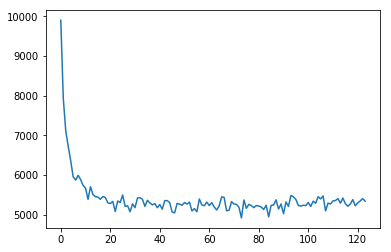

In [22]:
%matplotlib inline
pd.Series(losses_main).plot()


In [280]:
deverr_main_df = pd.DataFrame(deverr_main)
losses_main_df = pd.DataFrame(losses_main)

In [38]:
deverr_main_df.to_csv('obj1/deverr_main.csv', index = False)
losses_main_df.to_csv('obj1/losses_main.csv', index = False)

In [281]:
deverr_main_df['iter'] = pd.Series([80000,160000,240000,312752,392752, 472752,552752, 632752])
deverr_main_df.columns = ['Valid Error', 'Iter']
deverr_main_df

,Valid Error,Iter
0,0.283582,80000
1,0.293002,160000
2,0.290738,240000
3,0.332713,312752
4,0.274988,392752
5,0.294920,472752
6,0.303879,552752
7,0.331293,632752


In [291]:
losses_main_df['Iter'] = pd.Series(np.arange(5000,625000,5000))

In [285]:
losses_main_df.columns = ['Loss', 'Iter']

In [292]:
losses_main_df

,Loss,Iter
0,9903.533552,5000
1,7938.873726,10000
2,7113.220061,15000
3,6721.288463,20000
4,6359.099445,25000
5,5953.822776,30000
6,5869.217769,35000
7,5990.237041,40000
8,5883.741382,45000
9,5740.672676,50000


In [295]:
loss_error_merge = pd.merge(losses_main_df, deverr_main_df, on = 'Iter', how = 'outer')

In [299]:
loss_error_merge = loss_error_merge.sort_values(['Iter'], ascending = True)

In [301]:
loss_error_merge

,Loss,Iter,Valid Error
0,9903.533552,5000,NaN
1,7938.873726,10000,NaN
2,7113.220061,15000,NaN
3,6721.288463,20000,NaN
4,6359.099445,25000,NaN
5,5953.822776,30000,NaN
6,5869.217769,35000,NaN
7,5990.237041,40000,NaN
8,5883.741382,45000,NaN
9,5740.672676,50000,NaN


In [ ]:
plt.plot('Iter', 'Loss')

C:\Users\gonza\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


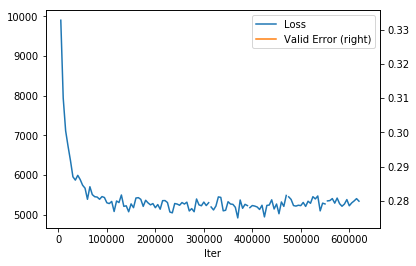

In [303]:
loss_error_merge.plot.line(x = 'Iter',
                             y = ['Loss', 'Valid Error'],
                             secondary_y = ['Valid Error'])

In [172]:
besterror_main

0.2749875302152477

CLASSIFYING TEST

In [23]:
test_classif_main = best_main.classify(test_list)

In [ ]:
pd.DataFrame(test_classif_main).to_csv('obj1/test_classif_main.csv', index = False)

In [191]:
test_classif_main_df = pd.DataFrame(test_classif_main, 
                                    columns = ['data_id', 'interaction', 'notes', 'pred'])

In [192]:
test_classif_main_df['correct'] = test_classif_main_df['interaction'] == test_classif_main_df['pred']

In [232]:
test_acc = test_classif_main_df.correct.mean()
test_acc

0.7226144342554579

OLS WITH KEY VARS

In [239]:
test_classif_main_df_vars = pd.merge(test_classif_main_df, conflict_df, on = 'data_id', how = 'left')

In [260]:
test_classif_main_df_vars['correct_int'] = test_classif_main_df_vars.correct.astype(int)

In [262]:
fit = smf.ols('correct_int ~ C(interaction_x) + C(year) + notes_char', test_classif_main_df_vars).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            correct_int   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     934.3
Date:                Mon, 03 Jun 2019   Prob (F-statistic):               0.00
Time:                        06:31:07   Log-Likelihood:                -17706.
No. Observations:               52126   AIC:                         3.550e+04
Df Residuals:                   52084   BIC:                         3.587e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.9505      0.007    141.122      0.000       0.937       0.964
C(interaction_x)[T.11]    -0.2698      0.011    -24.932      0.000      -0.291      -0.249
C(interaction_x)[T.12]     0.0538      0.007      7.582      0.000       0.040       0.068
C(interaction_x)[T.13]    -0.5507      0.010    -55.623      0.000      -0.570      -0.531
C(interaction_x)[T.14]    -0.8556      0.028    -30.209      0.000      -0.911      -0.800
C(interaction_x)[T.15]    -0.2332      0.012    -20.215      0.000      -0.256      -0.211
C(interaction_x)[T.16]    -0.2632      0.011    -23.404      0.000      -0.285      -0.241
C(interaction_x)[T.17]    -0.2592      0.009    -27.333      0.000      -0.278      -0.241
C(interaction_x)[T.18]    -0.1626      0.014    -11.827      0.000      -0.190      -0.136
C(interaction_x)[T.20]    -0.7882      0.013    -62.517      0.000      -0.813      -0.764
C(interaction_x)[T.22]    -0.3820      0.015    -26.063      0.000      -0.411      -0.353
C(interaction_x)[T.23]    -0.8225      0.016    -50.463      0.000      -0.854      -0.791
C(interaction_x)[T.24]    -0.8416      0.040    -21.035      0.000      -0.920      -0.763
C(interaction_x)[T.25]    -0.8599      0.095     -9.098      0.000      -1.045      -0.675
C(interaction_x)[T.26]    -0.8385      0.120     -6.963      0.000      -1.074      -0.602
C(interaction_x)[T.27]    -0.3260      0.012    -26.406      0.000      -0.350      -0.302
C(interaction_x)[T.28]    -0.5199      0.014    -37.498      0.000      -0.547      -0.493
C(interaction_x)[T.30]    -0.5780      0.013    -44.781      0.000      -0.603      -0.553
C(interaction_x)[T.33]    -0.7717      0.020    -38.139      0.000      -0.811      -0.732
C(interaction_x)[T.34]    -0.8717      0.048    -18.153      0.000      -0.966      -0.778
C(interaction_x)[T.35]    -0.8570      0.062    -13.730      0.000      -0.979      -0.735
C(interaction_x)[T.36]    -0.8818      0.095     -9.330      0.000      -1.067      -0.697
C(interaction_x)[T.37]    -0.2394      0.009    -26.629      0.000      -0.257      -0.222
C(interaction_x)[T.38]    -0.8612      0.015    -57.975      0.000      -0.890      -0.832
C(interaction_x)[T.40]    -0.8874      0.108     -8.239      0.000      -1.098      -0.676
C(interaction_x)[T.44]    -0.4109      0.021    -19.227      0.000      -0.453      -0.369
C(interaction_x)[T.45]    -0.8567      0.196     -4.362      0.000      -1.242      -0.472
C(interaction_x)[T.47]    -0.7299      0.016    -45.226      0.000      -0.761      -0.698
C(interaction_x)[T.48]    -0.8746      0.120     -7.266      0.000      -1.111      -0.639
C(interaction_x)[T.50]    -0.6646      0.013    -49.734      0.000      -0.691      -0.638
C(interaction_x)[T.55]    -0.6196      0.015    -40.242      0.000      -0.650  

ANALYSIS: ACCURACY BY INTERACTION CODES

getting variables and merging

In [193]:
error_int = pd.DataFrame(test_classif_main_df.groupby('interaction')['correct'].mean())

In [196]:
train_list_df = pd.DataFrame(train_list,
                             columns = ['data_id',
                                        'interaction',
                                        'notes'])

In [195]:
train_int = pd.DataFrame(train_list_df.groupby('interaction').size() / len(train_list), 
                         columns = ['per_train'])

In [203]:
train_list_df['train characters'] = train_list_df.notes.str.len()

In [214]:
train_char = pd.DataFrame(train_list_df.groupby('interaction')['train characters'].mean())

In [205]:
test_int = pd.DataFrame(test_classif_main_df.groupby('interaction').size() / len(test_list), 
                        columns = ['per_test'])

In [212]:
merge_inter = pd.merge(test_int.reset_index(), train_int.reset_index(), 
                       on = 'interaction', how = 'outer')

In [213]:
merge_inter = pd.merge(merge_inter, error_int.reset_index(), 
                       on = 'interaction', how = 'outer')

In [215]:
merge_inter = pd.merge(merge_inter, train_char.reset_index(), 
                       on = 'interaction', how = 'outer')

In [217]:
merge_inter.columns = ['interaction code', 'in test', 'in train', 'accuracy', 'characters']

graphing

In [ ]:
merge_inter = merge_inter.sort_values(['in train'], ascending = False)

C:\Users\gonza\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


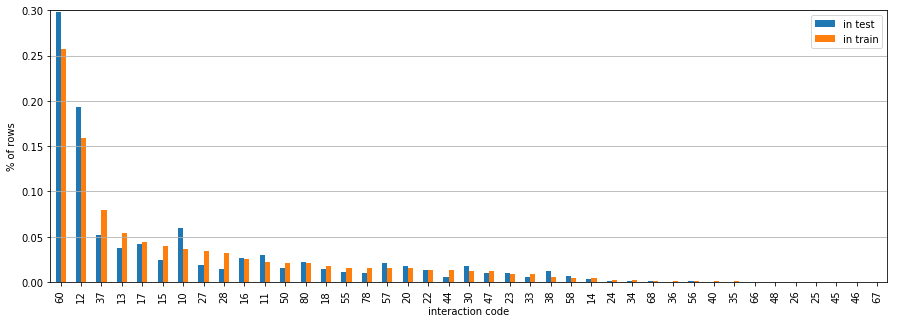

In [225]:
err2 = merge_inter.plot.bar(x = 'interaction code',
                                 y = ['in test', 'in train'],
                                 figsize = (15,5),
                            sort_columns = True
                            
                                )
err2.set_ylim(0, .3)
err2.set_ylabel('% of rows')
err2.grid('on', which='major', axis='y' )

In [227]:
merge_inter = merge_inter.sort_values(['accuracy'], ascending = False)

C:\Users\gonza\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


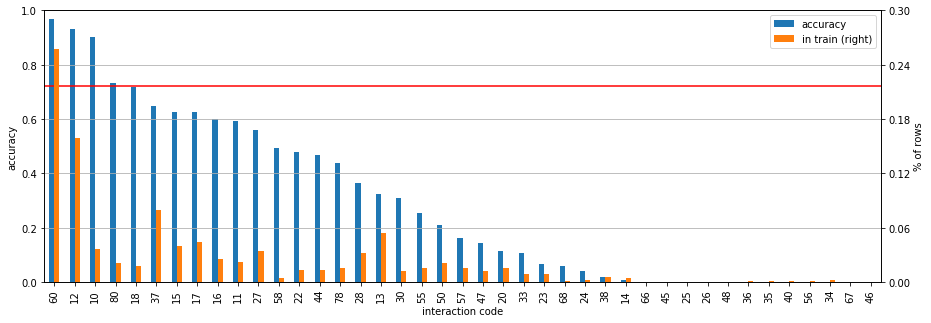

In [233]:
err1 = merge_inter.plot.bar(x = 'interaction code',
                                 y = ['accuracy', 'in train'],
                                 secondary_y = ['in train'],
                                 figsize = (15,5),
                            
                            sort_columns = True
                            
                                )
err1.set_ylim(0, 1)
err1.set_ylabel('accuracy')
err1.right_ax.set_ylim(0, .3)
err1.right_ax.set_yticks([0, 0.06, 0.12, 0.18, 0.24, 0.3])
err1.right_ax.set_ylabel('% of rows')
err1.axhline(y = (test_acc), color = 'red')
err1.grid('on', which='major', axis='y' )


C:\Users\gonza\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


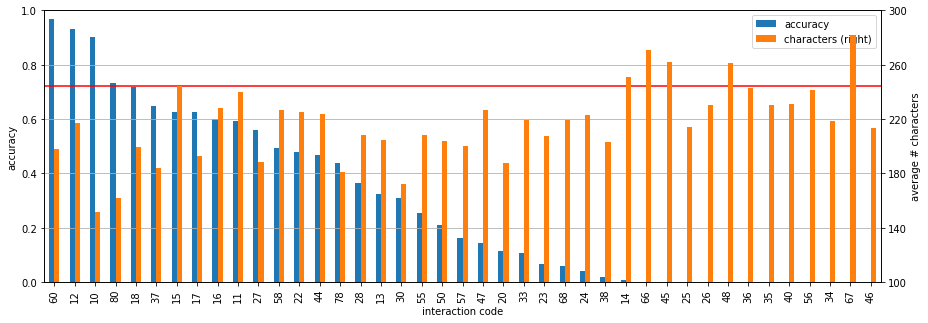

In [234]:
err3 = merge_inter.plot.bar(x = 'interaction code',
                                 y = ['accuracy', 'characters'],
                                 secondary_y = ['characters'],
                                 figsize = (15,5),
                            
                            sort_columns = True
                            
                                )
err3.set_ylim(0, 1)
err3.set_ylabel('accuracy')
err3.right_ax.set_ylim(100, 300)
err3.right_ax.set_yticks([100, 140, 180, 220, 260, 300])
err3.right_ax.set_ylabel('average # characters')
err3.axhline(y = (test_acc), color = 'red')
err3.grid('on', which='major', axis='y' )


In [311]:
train_df = pd.DataFrame(train_list, columns = ['data_id', 'interaction', 'notes'])

In [317]:
train_df[train_df['interaction']== 80]

,data_id,interaction,notes
10,4821646,80,The Saudi-led coalition carried out three air ...
38,4698595,80,Unidentified warplanes shelled areas in the to...
83,4768088,80,Unidentified warplanes carried out several rai...
202,4742916,80,19 raids of the coalition hit several regions ...
220,4781011,80,On 9 November 2016; an aircraft by US-led coal...
239,4675917,80,"In Red Sea port city of Hodeidah, the aggressi..."
259,5149663,80,Russian warplanes bombarded the Islamic State ...
289,4791149,80,The Saudi-led coalition carried out two air ra...
445,4746095,80,Unidentified warplanes carried out raids on th...
477,4709893,80,Warplanes carried out strikes on areas of Jam'...


RUNNING BASELINE SIMPLE LINEAR MODEL

In [26]:
class InterClassifierLinear(nn.Module):

    def __init__(self, categories_size, learn_rate = 0.001):
        super(InterClassifierLinear, self).__init__()
        
        self.linear1 = nn.Linear(300, categories_size)

        self.loss_function = nn.NLLLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learn_rate)


    def forward(self, inputs):
        # we ignore the embedding step since its included from spacy word2vec pre-trained model
        out = F.relu(self.linear1(inputs))
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
    
    def classify(self, docs):
        '''
        This function classifies/predicts documents into their categories. 
        '''
        classif = []
        with torch.no_grad():
            for data_id, target, note in docs:
                #vectorize in embeddings using spacy pre-trained model
                embeds = (nlp(note)).vector
                note_vec = torch.tensor([embeds])

                # spacy embedding is input of model
                log_probs = self.forward(note_vec)

                # fingin the max label
                pred_idx = ((torch.topk(log_probs, 1)[1])[0]).item()
                pred = idx_to_label[pred_idx]

                # storing into output
                classif.append((data_id, target, note, pred))
        return classif            
                
                
    def evaluate_classifier_accuracy(self, data):
        '''
        This function evaluates the data with the current model. 
        data contains both documents and labels. 
        It calls classify() to make predictions, 
        and compares with the correct labels to return 
        the model accuracy on "data". 
        '''

        error_sum = 0

        # calls classify to predict label in each case
        classif_dat = self.classify(data)

        # compares target to pred and calculates error rate
        for data_id, target, note, pred in classif_dat:
            if pred == target:
                error_sum = error_sum
            else:
                error_sum += 1
        error = error_sum/len(classif_dat)
        
        return error
    
    
    def train(self, training_list, development_list, n_epochs):
        
        losses = []
        dev_err = []
        error = 1
        
        for epoch in range(n_epochs):
            i = 0
            running_loss = 0.0
            for data_id, target, note in training_list:

                # cleaning gradiatent
                self.zero_grad()
                #print(target)
                #print(note)

                # vectorizing text using spacy pre-trained model
                embeds = (nlp(note)).vector
                #print(embeds)
                note_vec = torch.tensor([embeds])
                #print(note_vec)

                # including embedding into model and predicting
                predictions = self.forward(note_vec)

                # identifying target index
                target_idx = torch.tensor([label_to_idx[target]])
                #print('predictions \n:', predictions)
                #print(target_idx)

                # calculating loss and applying gradiant descent
                loss = self.loss_function(predictions, target_idx)
                #print(list(model.parameters()))
                loss.backward()
                self.optimizer.step()

                # print statistics of loss and dev error rate. Chunck taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
                i += 1
                running_loss += loss.item()
                if i % 5000 == 0:    # print average loss every 5,000
                    print('[%5d] loss: %.3f' % (i, running_loss / 5000))
                    losses.append(running_loss)
                    running_loss = 0.0
                if i % 80000 == 0 or i == 312752:    # check dev error every 20,000 and save best model
                    model_err = self.evaluate_classifier_accuracy(development_list)
                    print('dev error: ', model_err)
                    dev_err.append(model_err)
                    if model_err < error:
                        error = model_err
                        best_model = copy.deepcopy(self)

           
        return best_model, error, losses, dev_err
    

In [27]:
bl_model = InterClassifierLinear(41)

In [28]:
print(datetime.datetime.now())

2019-06-02 10:09:05.075634


In [29]:
best_bl, besterror_bl, losses_bl, deverr_bl = bl_model.train(train_list, dev_list, 2)

[ 5000] loss: 2.738
[10000] loss: 2.561
[15000] loss: 2.529
[20000] loss: 2.534
[25000] loss: 2.534
[30000] loss: 2.510
[35000] loss: 2.444
[40000] loss: 2.501
[45000] loss: 2.481
[50000] loss: 2.447
[55000] loss: 2.491
[60000] loss: 2.434
[65000] loss: 2.482
[70000] loss: 2.465
[75000] loss: 2.480
[80000] loss: 2.455
dev error:  0.5004796071058589
[85000] loss: 2.404
[90000] loss: 2.426
[95000] loss: 2.403
[100000] loss: 2.415
[105000] loss: 2.407
[110000] loss: 2.457
[115000] loss: 2.399
[120000] loss: 2.438
[125000] loss: 2.430
[130000] loss: 2.436
[135000] loss: 2.442
[140000] loss: 2.462
[145000] loss: 2.439
[150000] loss: 2.385
[155000] loss: 2.417
[160000] loss: 2.439
dev error:  0.4977362544603461
[165000] loss: 2.471
[170000] loss: 2.471
[175000] loss: 2.431
[180000] loss: 2.429
[185000] loss: 2.453
[190000] loss: 2.415
[195000] loss: 2.413
[200000] loss: 2.437
[205000] loss: 2.425
[210000] loss: 2.421
[215000] loss: 2.445
[220000] loss: 2.438
[225000] loss: 2.427
[230000] los

In [30]:
print(datetime.datetime.now())

2019-06-02 14:49:42.726975


In [31]:
# saving the best trained model 
torch.save(best_bl, "obj1/best_model_bl.pt")

C:\Users\gonza\Anaconda3\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type InterClassifierLinear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [32]:
#best_bl = torch.load("obj1/best_model_bl.pt")

In [39]:
deverr_bl_df = pd.DataFrame(deverr_bl)
losses_bl_df = pd.DataFrame(losses_bl)
deverr_bl_df.to_csv('obj1/deverr_bl.csv', index = False)
losses_bl_df.to_csv('obj1/losses_bl.csv', index = False)

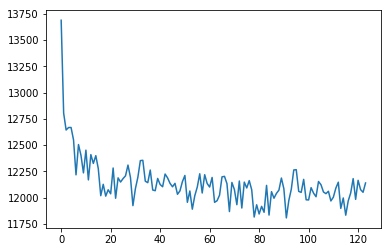

In [33]:
%matplotlib inline
pd.Series(losses_bl).plot()

In [34]:
test_classif_bl = best_bl.classify(test_list)

In [35]:
pd.DataFrame(test_classif_bl).to_csv('obj1/test_classif_bl.csv', index = False)
test_classif_bl_df = pd.DataFrame(test_classif_bl)

In [263]:
test_classif_bl_df = pd.DataFrame(test_classif_bl, 
                                    columns = ['data_id', 'interaction', 'notes', 'pred'])

In [264]:
test_classif_bl_df['correct'] = test_classif_bl_df['interaction'] == test_classif_bl_df['pred']

In [265]:
test_classif_bl_df.correct.mean()

0.5088823236005064

Check if suffling train/test. weight newest
move to cuda
less complexity
analysis of news that getting correct or not.
learning reate
Adam optimizer
Baseline: same embedding and logistic regression (remove 2nd and 3rd)

Include the number of characters. get accuracy of test data